# UltraLeap import playground



In [2]:
# Import public packages and functions
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress


import openpyxl
from datetime import datetime
from scipy.spatial import distance
#from scipy import signal
from scipy.ndimage import uniform_filter1d
import math
from scipy.signal import find_peaks, peak_prominences
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import statsmodels.api as sm
import statistics as stat
import json


In [3]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)
    
    return path

In [4]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')

In [5]:
os.chdir(code_path)
# Import own functions
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info

import sig_processing.segment_tasks as tasks

import movement_calc.calc_3d_distances as calc_3d
import movement_calc.helpfunctions as hp
import sig_processing.extract_features as feat_ext

Screentop

In [6]:
importlib.reload(hp)
data = import_dat.get_data(
            sub='009',
            cam_pos='st',
            task='ft',
            condition='m1',
            side='right',
        )
blocks = tasks.block_extraction(
            data, sub='009', task='ft', side='right',
            cond='m1', cam='st', to_save = False 
        )

for block in blocks.keys():

    dist = hp.calc_distances(blocks[block], ['index_tip', 'middle_tip', 'ring_tip', 'pinky_tip'], 'palm')
    idx_max, idx_min = hp.find_min_max(np.array(dist), cam='st')
    if blocks[block].shape[1] == data.shape[1]:
        blocks[block].insert(loc = 0, column = 'distances', value = dist)
    
    # idx_max, idx_min = hp.find_min_max(np.array(dist), cam='st')

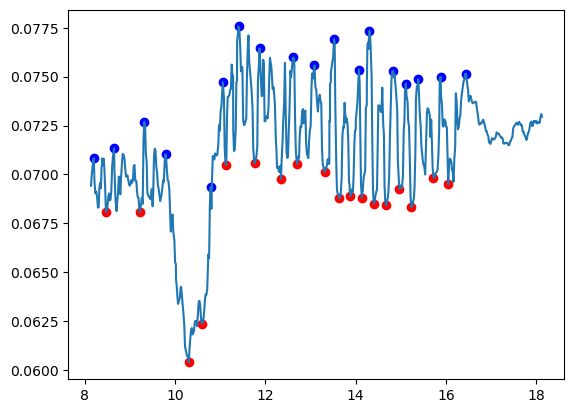

In [7]:
plt.plot(blocks['b1']['program_time'], blocks['b1']['distances'])
# plt.scatter(block.iloc[peaks_idx]['program_time'], block.iloc[peaks_idx]['distance'], color = 'red')
plt.scatter(blocks['b1'].iloc[idx_min]['program_time'], blocks['b1'].iloc[idx_min]['distances'], color = 'red')
plt.scatter(blocks['b1'].iloc[idx_max]['program_time'], blocks['b1'].iloc[idx_max]['distances'], color = 'blue')

### Functions iterating over subject files

Iterating over subjects

In [8]:
importlib.reload(import_dat)
importlib.reload(tasks)
importlib.reload(find_paths)
importlib.reload(feat_ext)

subs = find_paths.find_available_subs()
data = {}

# define variables of interest
ls_cam = ['dt', 'vr']
task = 'oc'
# ls_cond = ['m0s1', 'm1s0', 'm0s0', 'm1s1']
ls_cond = ['m1s0', 'm1s1']#, 'm1s1']
ls_side = ['left', 'right']

# for sub in subs:
    # print(sub) 
sub = '004'
for side in ls_side:
    for cam in ls_cam:
    # for cam in ['desktop']:

        for cond in ls_cond:
        # for cond in ['m1s0', 'm0s1']:

            # get defined data
            data = import_dat.get_data(
                sub=sub,
                cam_pos=cam,
                task=task,
                condition=cond,
                side=side,
            )
            # print('after get data')

            # get block dataframes
            blocks = tasks.block_extraction(
                data, sub=sub, task=task, side=side,
                cond=cond, cam=cam, to_save = True 
            )
            block_path = os.path.join(repo_path, 'data', 'raw_blocks', f'ul{sub}', task, cond)
            
            # print('after block extraction')
            # save raw_blocks in csv files
            for block in blocks.keys():
                if not os.path.exists(block_path): 
                    os.makedirs(block_path)
                blocks[block].to_csv(os.path.join(block_path, f'{block}_ul{sub}_{cond}_{cam}_{task}_{side}.csv'))

                # get distance per sample
                if task == 'oc':
                    dist = hp.calc_distances(blocks[block], ['index_tip', 'middle_tip', 'ring_tip','pinky_tip'], 'palm')
                elif task == 'ft':
                    dist = hp.calc_distances(blocks[block], 'index_tip', 'thumb_tip')
                elif task == 'ps':
                    dist = hp.PS_ang(blocks[block], 'thumb_tip', 'middle_tip', 'palm')
                else:
                    # function for postural tremor
                    print('postural tremor was not analysed yet')

                if blocks[block].empty:
                    print(f'{block}_{sub}_{cond}_{cam}_{task}_{side} is empty')
                    continue

                if blocks[block].shape[1] == data.shape[1]:
                    blocks[block].insert(loc = 0, column = 'distances', value = dist)
                
                # saving distance and time lists as csv files

                # get minima and maxima
                idx_max, idx_min = hp.find_min_max(np.array(dist), cam=cam)
                
                # get tap times
                time_per_tap = feat_ext.tap_times(blocks[block], idx_min)
                ls_time, ls_dist, tap_duration = feat_ext.ls_time_dist_tap(blocks[block], time_per_tap)
                spe_over_taps = feat_ext.speed_over_time_tap(ls_time, ls_dist)

                # extract features per tap
                ft_dict_tap, ft_name = feat_ext.get_feat_tap(ls_dist, spe_over_taps)

                ft_dict_block = feat_ext.get_feat_block(ft_dict_tap)

                # save feature lists and names to csv, excel -> use all variable in file-name
                ft_tap_path = os.path.join(repo_path, 'features', f'ul{sub}', task, block, cond)
                if not os.path.exists(ft_tap_path): 
                    os.makedirs(ft_tap_path)
            
                # ft_dict_open = open(os.path.join(ft_tap_path, f'ul{sub}', task, block, cond, f'fts_per_tap_{block}_ul{sub}_{cond}_{cam}_{task}_{side}.json'), 'w')
                ft_dict_open = open(os.path.join(ft_tap_path, f'fts_per_tap_{block}_ul{sub}_{cond}_{cam}_{task}_{side}.json'), 'w')
                json.dump(ft_dict_tap, ft_dict_open)
                ft_dict_open.close()

                ft_block_path = os.path.join(repo_path, 'features_per_block', f'ul{sub}', f'{task}', f'{block}')
                if not os.path.exists(ft_block_path): 
                    os.makedirs(ft_block_path)
            
                ft_dict_block_open = open(os.path.join(ft_block_path, f'{block}_ul{sub}_{cond}_{cam}_{task}_{side}.json'), 'w')
                json.dump(ft_dict_block, ft_dict_block_open)
                ft_dict_open.close()


c:\Users\madal\Thesis\ultraleap_analysis\code\sig_processing\extract_features.py:70: RuntimeWarning: divide by zero encountered in true_divide
  speed.append(dif_dist/dif_time)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
c:\Users\madal\Thesis\ultraleap_analysis\code\sig_processing\extract_features.py:70: RuntimeWarning: divide by zero encountered in true_divide
  speed.append(dif_dist/dif_time)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
c:\Users\madal\Thesis\ultraleap_analysis\code\sig_processing\extract_features.py:70: RuntimeWarning: divide by zero encountered in true_divide
  speed.append(dif_dist/dif_time)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\lib\nanfunction

b1_004_m1s0_dt_oc_right is empty
b2_004_m1s0_dt_oc_right is empty
b1_004_m1s1_dt_oc_right is empty


c:\Users\madal\Thesis\ultraleap_analysis\code\sig_processing\extract_features.py:70: RuntimeWarning: divide by zero encountered in true_divide
  speed.append(dif_dist/dif_time)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


In [7]:
importlib.reload(import_dat)
importlib.reload(tasks)
importlib.reload(find_paths)
importlib.reload(feat_ext)

subs = find_paths.find_available_subs()
data = {}

# define variables of interest
# cam = 'vr'
task = 'oc'
cam = 'dt'
# ls_cond = ['m0s1', 'm1s0']#, 'm0s0', 'm1s1']
cond = 'm1'#, 'm1s1']
ls_side = ['left', 'right']

# for sub in subs:
    # print(sub) 
sub = '001'
for side in ls_side:
    # for cam in ls_cam:
    # for cam in ['desktop']:

    #  for cond in ls_cond:
        # for cond in ['m1s0', 'm0s1']:

        # get defined data
    data = import_dat.get_data(
        sub=sub,
        cam_pos=cam,
        task=task,
        condition=cond,
        side=side,
    )
    # print('after get data')

    # get block dataframes
    blocks = tasks.block_extraction(
        data, sub=sub, task=task, side=side,
        cond=cond, cam=cam, to_save = True 
    )
    block_path = os.path.join(repo_path, 'data', 'raw_blocks', f'ul{sub}', task, cond)
    
    # print('after block extraction')
    # save raw_blocks in csv files
    for block in blocks.keys():


        if not os.path.exists(block_path): 
            os.makedirs(block_path)
        blocks[block].to_csv(os.path.join(block_path, f'{block}_ul{sub}_{cond}_{cam}_{task}_{side}.csv'))

        # print(blocks[block])
        # break

        # get distance per sample
        if task == 'oc':
            dist = hp.calc_distances(blocks[block], ['index_tip', 'middle_tip', 'ring_tip','pinky_tip'], 'palm')
        elif task == 'ft':
            dist = hp.calc_distances(blocks[block], 'index_tip', 'thumb_tip')
        elif task == 'ps':
            dist = hp.PS_ang(blocks[block], 'thumb_tip', 'middle_tip', 'palm')
        else:
            # function for postural tremor
            print('postural tremor was not analysed yet')
        print(blocks[block])
        if blocks[block].empty:
            print(f'{block}_{sub}_{cond}_{cam}_{task}_{side} is empty')
            continue

        if blocks[block].shape[1] == data.shape[1]:
            blocks[block].insert(loc = 0, column = 'distances', value = dist)
        
        # saving distance and time lists as csv files

        # get minima and maxima
        idx_max, idx_min = hp.find_min_max(np.array(dist), cam=cam)
        
        # get tap times
        time_per_tap = feat_ext.tap_times(blocks[block], idx_min)
        ls_time, ls_dist, tap_duration = feat_ext.ls_time_dist_tap(blocks[block], time_per_tap)
        spe_over_taps = feat_ext.speed_over_time_tap(ls_time, ls_dist)

        # extract features per tap
        ft_dict_tap, ft_name = feat_ext.get_feat_tap(ls_dist, spe_over_taps)

        ft_dict_block = feat_ext.get_feat_block(ft_dict_tap)

        # save feature lists and names to csv, excel -> use all variable in file-name
        ft_tap_path = os.path.join(repo_path, 'features', f'ul{sub}', task, block, cond)
        if not os.path.exists(ft_tap_path): 
            os.makedirs(ft_tap_path)
    
        # ft_dict_open = open(os.path.join(ft_tap_path, f'ul{sub}', task, block, cond, f'fts_per_tap_{block}_ul{sub}_{cond}_{cam}_{task}_{side}.json'), 'w')
        ft_dict_open = open(os.path.join(ft_tap_path, f'fts_per_tap_{block}_ul{sub}_{cond}_{cam}_{task}_{side}.json'), 'w')
        json.dump(ft_dict_tap, ft_dict_open)
        ft_dict_open.close()

        ft_block_path = os.path.join(repo_path, 'features_per_block', f'ul{sub}', f'{task}', f'{block}')
        if not os.path.exists(ft_block_path): 
            os.makedirs(ft_block_path)
    
        ft_dict_block_open = open(os.path.join(ft_block_path, f'{block}_ul{sub}_{cond}_{cam}_{task}_{side}.json'), 'w')
        json.dump(ft_dict_block, ft_dict_block_open)
        ft_dict_open.close()


        global_time  program_time  delta_time  thumb_metacarp_x  \
0     11:21:38:3939       81.5911      0.0010            0.0177   
1     11:21:38:4071       81.6044      0.0011            0.0173   
2     11:21:38:4166       81.6139      0.0015            0.0169   
3     11:21:38:4285       81.6258      0.0011            0.0165   
4     11:21:38:4410       81.6383      0.0011            0.0162   
...             ...           ...         ...               ...   
5012  11:22:39:4341      142.6314      0.0013           -0.0019   
5013  11:22:39:4466      142.6438      0.0015           -0.0035   
5014  11:22:39:4571      142.6543      0.0016           -0.0070   
5015  11:22:39:4692      142.6664      0.0010           -0.0108   
5016  11:22:39:4795      142.6768      0.0010           -0.0158   

      thumb_metacarp_y  thumb_metacarp_z  thumb_interphal_prox_x  \
0               0.1867           -0.1277                  0.0673   
1               0.1890           -0.1261                  0

c:\Users\madal\Thesis\ultraleap_analysis\code\sig_processing\extract_features.py:70: RuntimeWarning: divide by zero encountered in true_divide
  speed.append(dif_dist/dif_time)
c:\Users\madal\Anaconda3\envs\ultraleap\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


### Load .json files with features

Plotting features per scores

In [5]:
def plot_feat_score(sub, task, cam, colour, cond, block, score, feat): 

    if cam == 'dt' or cam == 'vr':
        feat_open = open(os.path.join(repo_path,'features_per_block', sub, task, block, f'{block}_{sub}_{cond}_{cam}_{task}_right.json'))
        feat_load = json.load(feat_open)

        if cond == 'm1s0': marker_type = 'v'
        elif cond == 'm0s1': marker_type = 'o'
        else: 
            marker_type = '^'
        
        plt.scatter(score, feat_load[feat], marker = marker_type, color = colour)
        plt.ylabel(feat)
        plt.xlabel('score')
        plt.xticks([1,2,3])
        plt.xlim(1.5,3.5)
        plt.title('UPDRS sub-scores for patients in different conditions')
        plt.tight_layout()


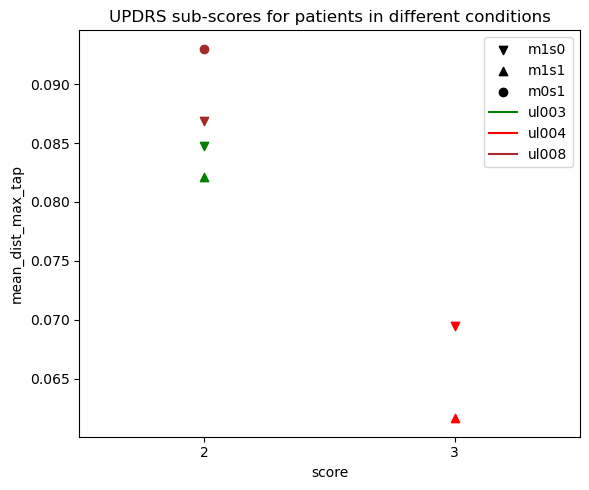

In [7]:
fig = plt.figure(figsize=(6,5))
plot_feat_score('ul003', 'oc', 'vr', 'green', 'm1s0', 'b1', 2, 'mean_dist_max_tap')
plot_feat_score('ul003', 'oc', 'vr', 'green', 'm1s1', 'b1', 2, 'mean_dist_max_tap')
plot_feat_score('ul004', 'oc', 'vr', 'red', 'm1s0', 'b1', 3, 'mean_dist_max_tap')
plot_feat_score('ul004', 'oc', 'vr', 'red', 'm1s1', 'b1', 3, 'mean_dist_max_tap')
plot_feat_score('ul008', 'oc', 'vr', 'brown', 'm1s0', 'b1', 2, 'mean_dist_max_tap')
plot_feat_score('ul008', 'oc', 'vr', 'brown', 'm0s1', 'b1', 2, 'mean_dist_max_tap')

plt.scatter([],[], color='k', marker='v', label='m1s0')
plt.scatter([],[], color='k', marker='^', label='m1s1')
plt.scatter([],[], color='k', marker='o', label='m0s1')

plt.plot([], color='green', label = 'ul003')
plt.plot([], color='red', label = 'ul004')
plt.plot([], color='brown', label = 'ul008')

plt.legend()

plt.show()

fig_path = os.path.join(repo_path,
        'presentations',
        'figures',
        )
if not os.path.exists(fig_path): 
    os.makedirs(fig_path)

fig.savefig(
    os.path.join(fig_path, f'feat_mean_dist_max_tap_patients_per_score_oc'),
    dpi = 300, facecolor = 'w',
    )

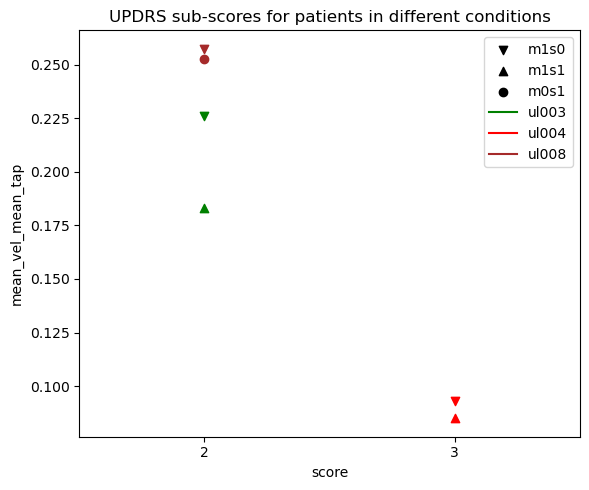

In [8]:
fig = plt.figure(figsize=(6,5))
plot_feat_score('ul003', 'oc', 'vr', 'green', 'm1s0', 'b1', 2, 'mean_vel_mean_tap')
plot_feat_score('ul003', 'oc', 'vr', 'green', 'm1s1', 'b1', 2, 'mean_vel_mean_tap')
plot_feat_score('ul004', 'oc', 'vr', 'red', 'm1s0', 'b1', 3, 'mean_vel_mean_tap')
plot_feat_score('ul004', 'oc', 'vr', 'red', 'm1s1', 'b1', 3, 'mean_vel_mean_tap')
plot_feat_score('ul008', 'oc', 'vr', 'brown', 'm1s0', 'b1', 2, 'mean_vel_mean_tap')
plot_feat_score('ul008', 'oc', 'vr', 'brown', 'm0s1', 'b1', 2, 'mean_vel_mean_tap')

plt.scatter([],[], color='k', marker='v', label='m1s0')
plt.scatter([],[], color='k', marker='^', label='m1s1')
plt.scatter([],[], color='k', marker='o', label='m0s1')

plt.plot([], color='green', label = 'ul003')
plt.plot([], color='red', label = 'ul004')
plt.plot([], color='brown', label = 'ul008')

plt.legend()

plt.show()

fig_path = os.path.join(repo_path,
        'presentations',
        'figures',
        )
if not os.path.exists(fig_path): 
    os.makedirs(fig_path)

fig.savefig(
    os.path.join(fig_path, f'feat_mean_vel_mean_tap_patients_per_score'),
    dpi = 300, facecolor = 'w',
    )

In [360]:
def plot_feat_per_score(ls_sub, task, cam, ls_colour, ls_cond, block, scores, feat):

    i = 0
    
    # for sub, c in zip(os.listdir(os.path.join(repo_path,'features_per_block'))[2:4], ls_colour):
    for sub, c in zip(ls_sub, ls_colour):
        for cond in ls_cond:
        
            if cam == 'dt' or cam == 'vr':
                feat_open = open(os.path.join(repo_path,'features_per_block', sub, task, block, f'{block}_{sub}_{cond}_{cam}_{task}_right.json'))
                feat_load = json.load(feat_open)

                if cond == 'm1s0': marker_type = 'o'
                elif cond == 'm1s1': marker_type = '^'

                plt.scatter(scores[i], feat_load[feat], marker = marker_type, color = c)
                plt.legend(ls_cond)
                plt.ylabel(feat)
                plt.xlabel('score')
                plt.xticks([1,2,3])
                plt.title('Comparison of scores between patients with different conditions')

                i+=1

In [ ]:
plot_feat_per_score(['ul003', 'ul004', 'ul008'], 'oc', 'vr', ['blue', 'green', 'orange'], ['m1s0', 'm1s1'], 'b1', [1, 1, 2, 3], 'mean_dist_max_tap')

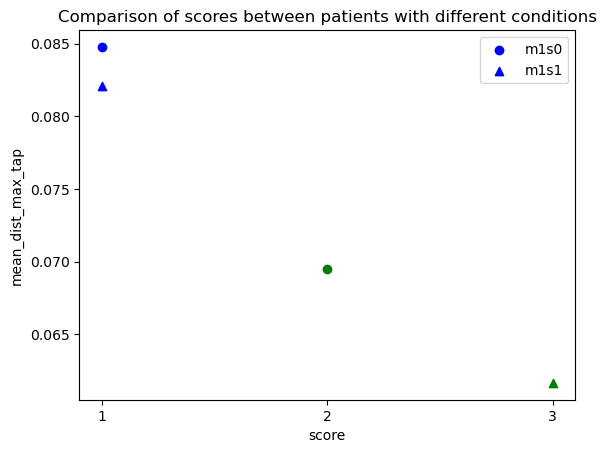

In [256]:
plot_feat_per_score('oc', 'vr', ['blue','green'], ['m1s0', 'm1s1'], 'b1', [1, 1, 2, 3], 'mean_dist_max_tap')


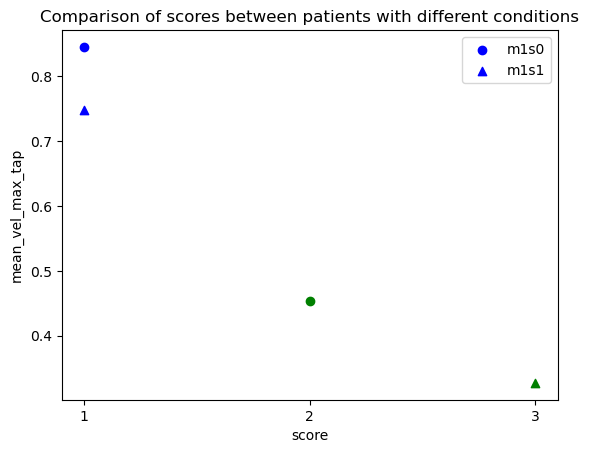

In [9]:
plot_feat_per_score('oc', 'vr', ['blue','green'], ['m1s0', 'm1s1'], 'b1', [1, 1, 2, 3], 'mean_vel_max_tap')

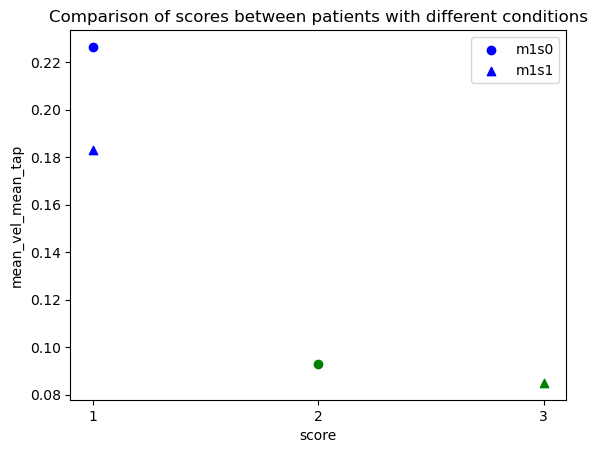

In [10]:
plot_feat_per_score('oc', 'vr', ['blue','green'], ['m1s0', 'm1s1'], 'b1', [1, 1, 2, 3], 'mean_vel_mean_tap')

In [59]:
feat_open = open(os.path.join(repo_path,'features', 'ul003', 'oc', 'b1', 'm1s0', f'fts_per_tap_b1_ul003_m1s0_dt_oc_right.json'))
feat_load = json.load(feat_open)

Features per time

In [17]:
def feat_over_tap(sub, task, cond, cam, block, side, feat_name,):

    block_path = pd.read_csv(os.path.join(repo_path, 'data','raw_blocks', sub, task, cond, f'{block}_{sub}_{cond}_{cam}_{task}_{side}.csv'))
    get_time = block_path.program_time.to_list()
    get_feat = json.load(open(os.path.join(repo_path, 'features', sub, task, block, cond, f'fts_per_tap_{block}_{sub}_{cond}_{cam}_{task}_{side}.json'))) 
    n_taps = np.arange(0,len(get_feat[feat_name]))
  
    plt.plot(n_taps, get_feat[feat_name], marker = 'o', ms = 2)
    plt.xlabel('# oc events')
    if 'dist' in feat_name:
        plt.ylabel('distance (m)')
        plt.title(feat_name)
        # plt.legend([legend_name])
    elif 'vel' in feat_name:
        plt.ylabel('speed (m/s)')
        plt.title(feat_name)
        # plt.legend([legend_name])
    elif feat_name == 'rms':
        plt.ylabel('distance (m)')
        plt.title(feat_name)


    return #get_feat[feat_name]

In [279]:
repo_path

'c:\\Users\\madal\\Thesis\\ultraleap_analysis'

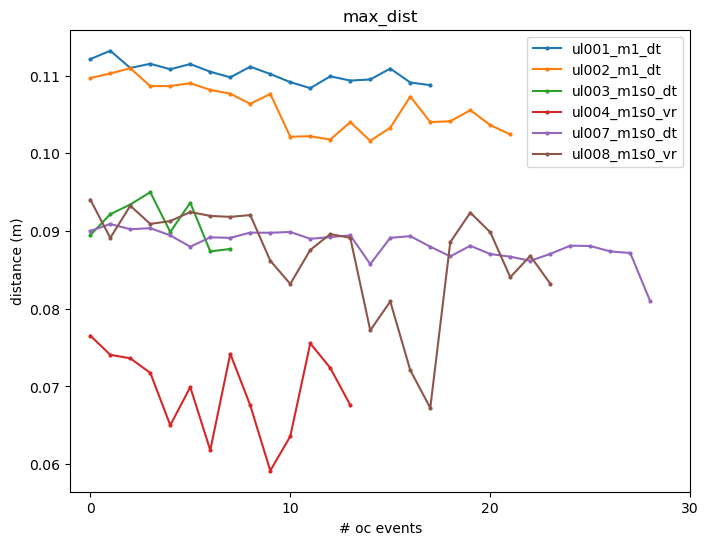

In [42]:
fig = plt.figure(figsize=(8,6))
feat_over_tap('ul001','oc','m1','vr', 'b1', 'right', 'max_dist')
feat_over_tap('ul002','oc','m1','dt', 'b1', 'right', 'max_dist')
feat_over_tap('ul003','oc','m1s0','dt', 'b1', 'right', 'max_dist')
# feat_over_tap('ul003','oc','m1s1','dt', 'b1', 'right', 'max_dist')
feat_over_tap('ul004','oc','m1s0','vr', 'b1', 'right', 'max_dist')
# feat_over_tap('ul004','oc','m1s1','vr', 'b1', 'right', 'max_dist')
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'max_dist')
# feat_over_tap('ul007','oc','m1s1','vr', 'b1', 'right', 'max_dist')
feat_over_tap('ul008','oc','m1s0','vr', 'b1', 'right','max_dist')
# feat_over_tap('ul008','oc','m1s1','dt', 'b1', 'right','max_dist')

# plt.legend(['ul001_m1_dt', 'ul002_m1_dt', 'ul003_m1s0_dt', 'ul003_m1s1_dt', 'ul004_m1s0_vr', 'ul004_m1s1_vr', 'ul007_m1s0_dt', 'ul007_m1s1_vr', 'ul008_m1s0_vr', 'ul008_m1s1_dt'])
plt.legend(['ul001_m1_dt', 'ul002_m1_dt', 'ul003_m1s0_dt', 'ul004_m1s0_vr', 'ul007_m1s0_dt', 'ul008_m1s0_vr'])
plt.xticks([0,10,20,30])
plt.xlim(-1,30)
fig_path = os.path.join(repo_path,
        'presentations',
        'figures',
        )
if not os.path.exists(fig_path): 
    os.makedirs(fig_path)

fig.savefig(
    os.path.join(fig_path, f'feat_max_dist_per_tap_patients_only_m1s0_m1_b1'),
    dpi = 300, facecolor = 'w',
    )



ul007 - Decrement

% decrement between 1st 3 and last 3 open-close movements: 5.773962233088776 %
-0.16665050280710947


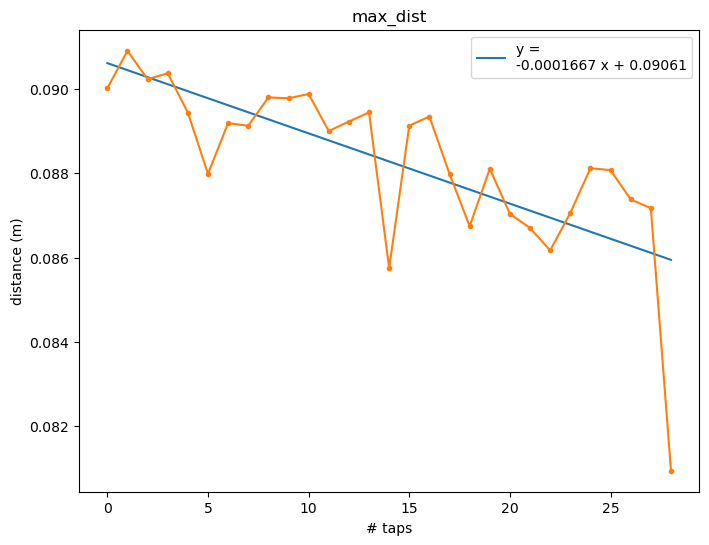

In [267]:
feat_open = open(os.path.join(repo_path,'features', 'ul007', 'oc', 'b1', 'm1s0', f'fts_per_tap_b1_ul007_m1s0_dt_oc_right.json'))
feat_load = json.load(feat_open)

taps = np.arange(0,len(feat_load['max_dist']))
linear_model_amp = np.polyfit(taps, feat_load['max_dist'], 1)
linear_model_fn_amp = np.poly1d(linear_model_amp)

fig = plt.figure(figsize=(8,6))
plt.plot(
        taps,
        linear_model_fn_amp(taps),
        label = f'y = {linear_model_fn_amp}'
        )
plt.legend()
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'max_dist')

dec = ((np.nanmean(feat_load['max_dist'][0:3])-np.nanmean(feat_load['max_dist'][-3:]))/np.nanmean(feat_load['max_dist'][0:3]))*100
print(f'% decrement between 1st 3 and last 3 open-close movements: {dec} %')

# decrement of cm/per 10 taps
print(f'{linear_model_fn_amp[1]*1000}')


ul002 - Decrement

% decrement between 1st 3 and last 3 open-close movements: 5.833492892752392 %
-0.357513141937422


<Figure size 640x480 with 0 Axes>

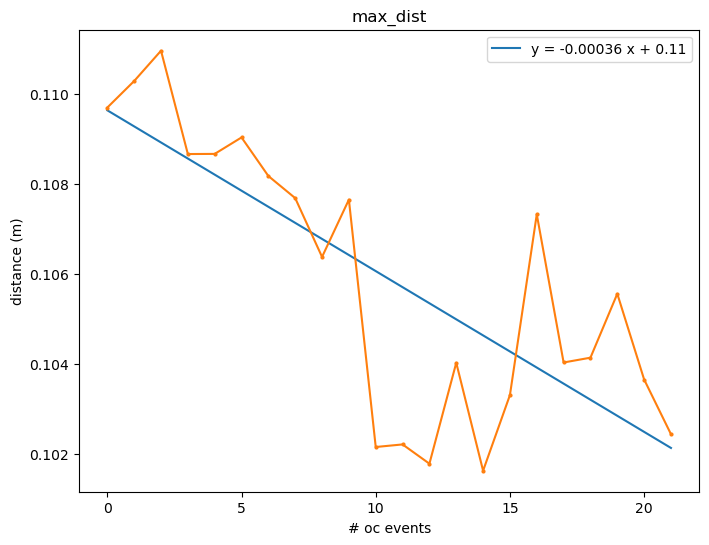

In [48]:
fig = plt.figure()
feat_open = open(os.path.join(repo_path,'features', 'ul002', 'oc', 'b1', 'm1', f'fts_per_tap_b1_ul002_m1_dt_oc_right.json'))
feat_load = json.load(feat_open)

taps = np.arange(0,len(feat_load['max_dist']))
linear_model_amp = np.polyfit(taps, feat_load['max_dist'], 1)
linear_model_fn_amp = np.poly1d(linear_model_amp)

fig = plt.figure(figsize=(8,6))
plt.plot(
        taps,
        linear_model_fn_amp(taps),
        label = 'y = -0.00036 x + 0.11'  #f'y = {linear_model_fn_amp}' 
        )
plt.legend()
feat_over_tap('ul002','oc','m1','dt', 'b1', 'right', 'max_dist')

dec = ((np.nanmean(feat_load['max_dist'][0:3])-np.nanmean(feat_load['max_dist'][-3:]))/np.nanmean(feat_load['max_dist'][0:3]))*100
print(f'% decrement between 1st 3 and last 3 open-close movements: {dec} %')

# decrement of cm/per 10 taps
print(f'{linear_model_fn_amp[1]*1000}')

fig_path = os.path.join(repo_path,
        'presentations',
        'figures',
        )
if not os.path.exists(fig_path): 
    os.makedirs(fig_path)

fig.savefig(
    os.path.join(fig_path, f'feat_max_dist_per_tap_decrement_ul002'),
    dpi = 300, facecolor = 'w',
    )


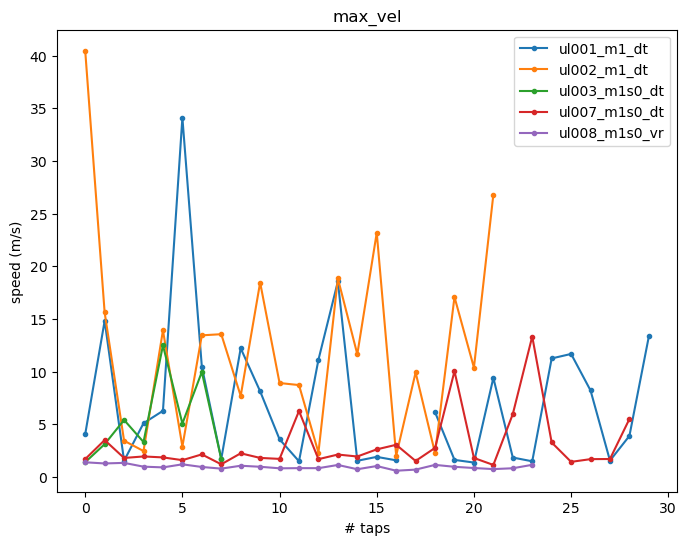

In [247]:
fig = plt.figure(figsize=(8,6))
feat_over_tap('ul001','oc','m1','dt', 'b1', 'right', 'max_vel')
feat_over_tap('ul002','oc','m1','dt', 'b1', 'right', 'max_vel')
feat_over_tap('ul003','oc','m1s0','dt', 'b1', 'right', 'max_vel')
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'max_vel')
feat_over_tap('ul008','oc','m1s0','vr', 'b1', 'right','max_vel')
plt.legend(['ul001_m1_dt', 'ul002_m1_dt', 'ul003_m1s0_dt', 'ul007_m1s0_dt', 'ul008_m1s0_vr'])

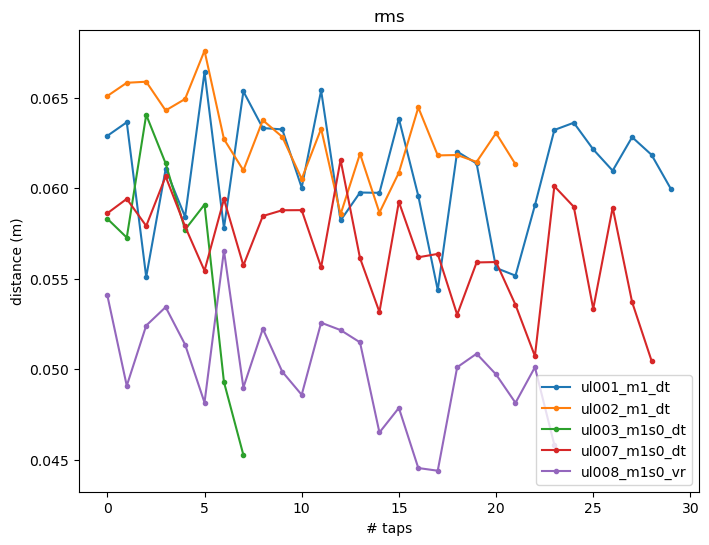

In [248]:
fig = plt.figure(figsize=(8,6))
feat_over_tap('ul001','oc','m1','dt', 'b1', 'right', 'rms')
feat_over_tap('ul002','oc','m1','dt', 'b1', 'right', 'rms')
feat_over_tap('ul003','oc','m1s0','dt', 'b1', 'right', 'rms')
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'rms')
feat_over_tap('ul008','oc','m1s0','vr', 'b1', 'right','rms')
plt.legend(['ul001_m1_dt', 'ul002_m1_dt', 'ul003_m1s0_dt', 'ul007_m1s0_dt', 'ul008_m1s0_vr'], loc = 'best')

Comparing ul007 different conditions

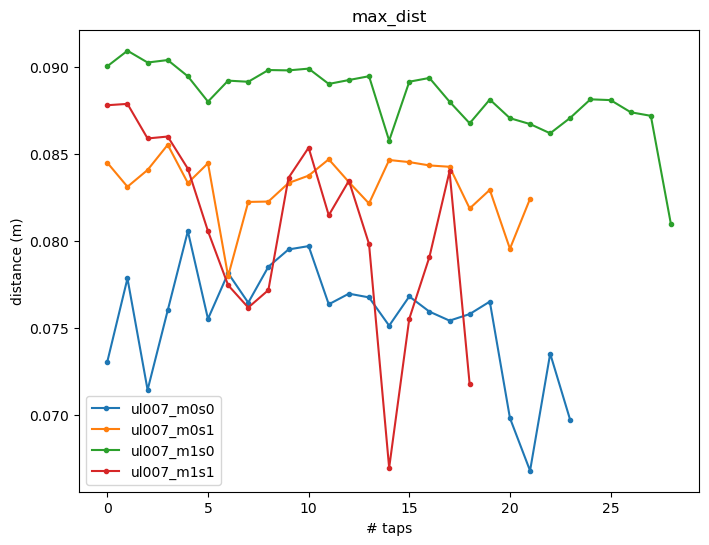

In [249]:
fig = plt.figure(figsize=(8,6))
feat_over_tap('ul007','oc','m0s0','vr', 'b1', 'right', 'max_dist')
feat_over_tap('ul007','oc','m0s1','dt', 'b1', 'right', 'max_dist')
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'max_dist')
feat_over_tap('ul007','oc','m1s1','vr', 'b1', 'right', 'max_dist')
plt.legend(['ul007_m0s0', 'ul007_m0s1', 'ul007_m1s0', 'ul007_m1s1'])



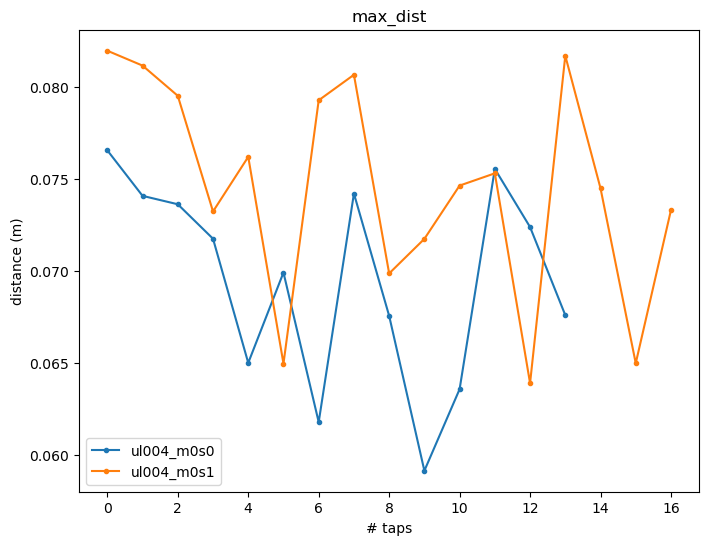

In [251]:
fig = plt.figure(figsize=(8,6))
feat_over_tap('ul004','oc','m1s0','vr', 'b1', 'right', 'max_dist')
feat_over_tap('ul004','oc','m1s1','dt', 'b1', 'right', 'max_dist')
# feat_over_tap('ul003','oc','m1s0','dt', 'b1', 'right', 'max_dist')
# feat_over_tap('ul003','oc','m1s1','vr', 'b1', 'right', 'max_dist')
plt.legend(['ul004_m0s0', 'ul004_m0s1'])#, 'ul003_m1s0', 'ul003_m1s1'])

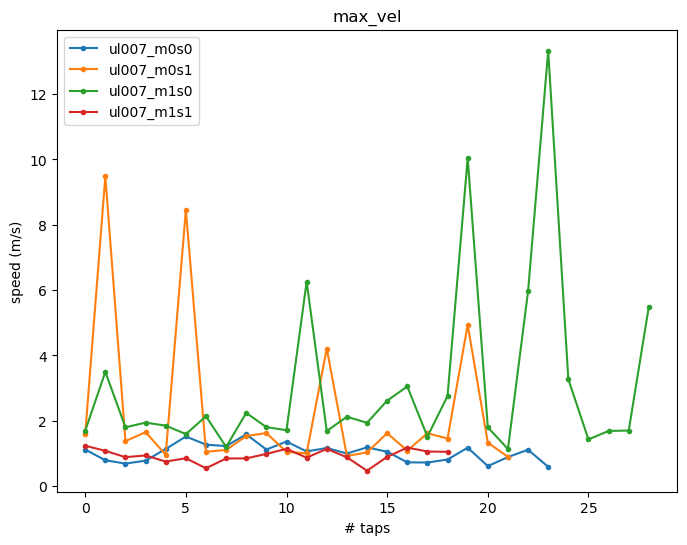

In [235]:
fig = plt.figure(figsize=(8,6))
feat_over_tap('ul007','oc','m0s0','vr', 'b1', 'right', 'max_vel')
feat_over_tap('ul007','oc','m0s1','dt', 'b1', 'right', 'max_vel')
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'max_vel')
feat_over_tap('ul007','oc','m1s1','vr', 'b1', 'right', 'max_vel')
plt.legend(['ul007_m0s0', 'ul007_m0s1', 'ul007_m1s0', 'ul007_m1s1'])


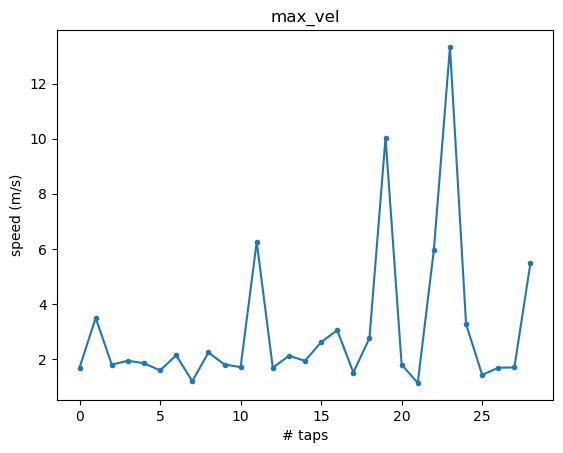

In [254]:
feat_over_tap('ul007','oc','m1s0','dt', 'b1', 'right', 'max_vel')

Function to exctract Updrs scores

In [15]:
from import_data.find_paths import find_onedrive_path
def extract_scores(cam: str, task: str, side: str):

    scores = pd.read_excel(os.path.join(
                find_onedrive_path('patientdata'), 'overview_participants.xlsx'))
    
    ls_scores = []

    for i, sub in enumerate(scores.subject):
        ls_scores.append(scores.iloc[i][f'{cam}_{task}_scores_{side}'])
    print(ls_scores)    
    return ls_scores

In [16]:
scores = pd.read_excel(os.path.join(
                find_onedrive_path('patientdata'), 'overview_participants.xlsx'))


In [17]:
hi = extract_scores('dt', 'ft', 'left')


[nan, nan, '1, 1', '1, 1', '2, 2', '2, 2', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [90]:
sub = 'ul004'
task = 'oc'
sub_files = os.listdir(os.path.join(repo_path,'features', sub, task))
sub_files

['fts_b1_ul004_m1s0_dt_oc_left.json',
 'fts_b1_ul004_m1s0_vr_oc_left.json',
 'fts_b1_ul004_m1s0_vr_oc_right.json',
 'fts_b1_ul004_m1s1_dt_oc_left.json',
 'fts_b1_ul004_m1s1_vr_oc_left.json',
 'fts_b1_ul004_m1s1_vr_oc_right.json',
 'fts_b2_ul004_m1s0_dt_oc_left.json',
 'fts_b2_ul004_m1s0_vr_oc_left.json',
 'fts_b2_ul004_m1s0_vr_oc_right.json',
 'fts_b2_ul004_m1s1_dt_oc_left.json',
 'fts_b2_ul004_m1s1_dt_oc_right.json',
 'fts_b2_ul004_m1s1_vr_oc_left.json',
 'fts_b2_ul004_m1s1_vr_oc_right.json']

In [105]:
block_n = 'b1'

cond = ['m1s0', 'm1s1']
# cond = ['m0s1', 'm1s0']
# cond = ['m0s0', 'm1s1']

cam = 'vr'

select_files_l = []
select_files_r = []

block_files = [f for f in sub_files if block_n in f]

for file in block_files:
    if 'left' in file and cam in file:
        if cond[0] in file: 
            f1 = file
            select_files_l.append(f1)
        elif cond[1] in file: 
            f2 = file
            select_files_l.append(f2)
    if 'right' in file and cam in file:
        if cond[0] in file: 
            f3 = file
            select_files_r.append(f3)
        elif cond[1] in file: 
            f4 = file
            select_files_r.append(f4)

In [106]:
block_files

['fts_b1_ul004_m1s0_dt_oc_left.json',
 'fts_b1_ul004_m1s0_vr_oc_left.json',
 'fts_b1_ul004_m1s0_vr_oc_right.json',
 'fts_b1_ul004_m1s1_dt_oc_left.json',
 'fts_b1_ul004_m1s1_vr_oc_left.json',
 'fts_b1_ul004_m1s1_vr_oc_right.json']

In [107]:
select_files_l

['fts_b1_ul004_m1s0_vr_oc_left.json', 'fts_b1_ul004_m1s1_vr_oc_left.json']

In [108]:
select_files_r

['fts_b1_ul004_m1s0_vr_oc_right.json', 'fts_b1_ul004_m1s1_vr_oc_right.json']

In [109]:
sub = 'ul004'


In [110]:
sub = 'ul004'
feat_names_dist = ['rms', 'max_dist', 'mean_dist', 'std_dist']#['max_vel', 'mean_vel', 'std_vel']

list_os_features_1 = []
boxplot_of_features = {}
for i in feat_names_dist:
    boxplot_of_features[i] = []

for file_l, file_r in zip(select_files_l, select_files_r):
    print(file_l, file_r)
    open_file_l = open(os.path.join(repo_path,'features', sub, task, file_l))
    ft_dict_l = json.load(open_file_l)
    
    open_file_r = open(os.path.join(repo_path,'features', sub, task, file_r))
    ft_dict_r = json.load(open_file_r)

    for f in feat_names_dist:
        boxplot_of_features[f].append(ft_dict_l[f])
        boxplot_of_features[f].append(ft_dict_r[f])
    

fts_b1_ul004_m1s0_vr_oc_left.json fts_b1_ul004_m1s0_vr_oc_right.json
fts_b1_ul004_m1s1_vr_oc_left.json fts_b1_ul004_m1s1_vr_oc_right.json


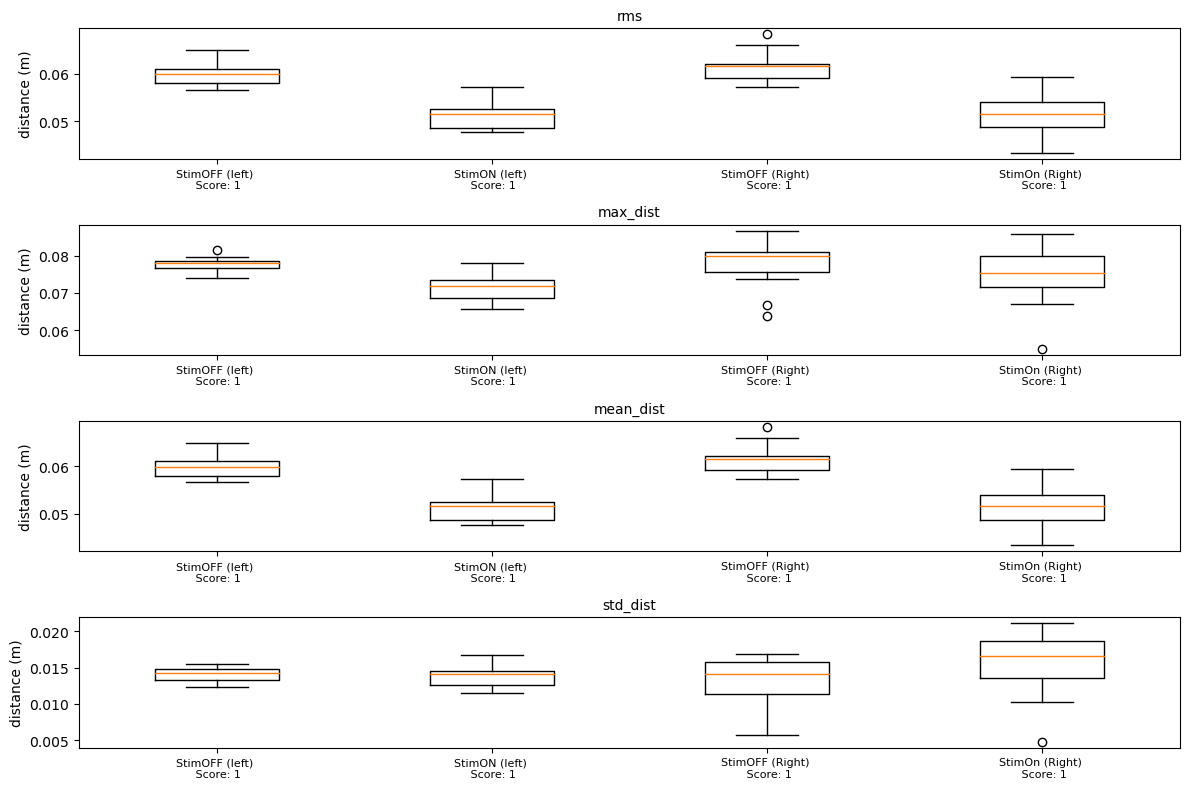

In [111]:
fig, axes = plt.subplots(len(boxplot_of_features.keys()), 1, figsize=(12, 8))

feat_names_dist = ['rms', 'max_dist', 'mean_dist', 'std_dist']#, 'max_vel', 'mean_vel', 'std_vel']
ylabels = ['distance (m)','distance (m)', 'distance (m)', 'distance (m)']#, 'speed (m/s)', 'speed (m/s)', 'speed (m/s)']
xticklabels = ['StimOFF (left) \n Score: 1', 'StimON (left) \n Score: 1', 'StimOFF (Right) \n Score: 1', 'StimOn (Right) \n Score: 1']

for n, feat in enumerate(feat_names_dist):

#    axes[n].boxplot(feat_patients[feat].values.tolist())
    axes[n].boxplot(boxplot_of_features[feat])
    
    axes[n].set_title(feat, fontsize = 10)
    axes[n].set_xticklabels(xticklabels, fontsize = 8)
    axes[n].set_ylabel(ylabels[n])
    # axes[n].set_xlabel()

plt.tight_layout()
# fig.savefig(
#             os.path.join(fig_dir[3], 'ul004_m1sX_vr_oc_dist_spe_boxplot'),
#             dpi = 300, facecolor = 'w',
#         )
plt.show()

In [113]:
feat_names_vel = ['max_vel', 'mean_vel', 'std_vel']

list_os_features_1 = []
boxplot_of_features = {}
for i in feat_names_vel:
    boxplot_of_features[i] = []

for file_l, file_r in zip(select_files_l, select_files_r):
    open_file_l = open(os.path.join(repo_path,'features', sub, task, file_l))
    load_file_l = json.load(open_file_l)
    
    open_file_r = open(os.path.join(repo_path,'features', sub, task, file_r))
    load_file_r = json.load(open_file_r)

    for f in feat_names_vel:
        boxplot_of_features[f].append(load_file_l[f])
        boxplot_of_features[f].append(load_file_r[f])

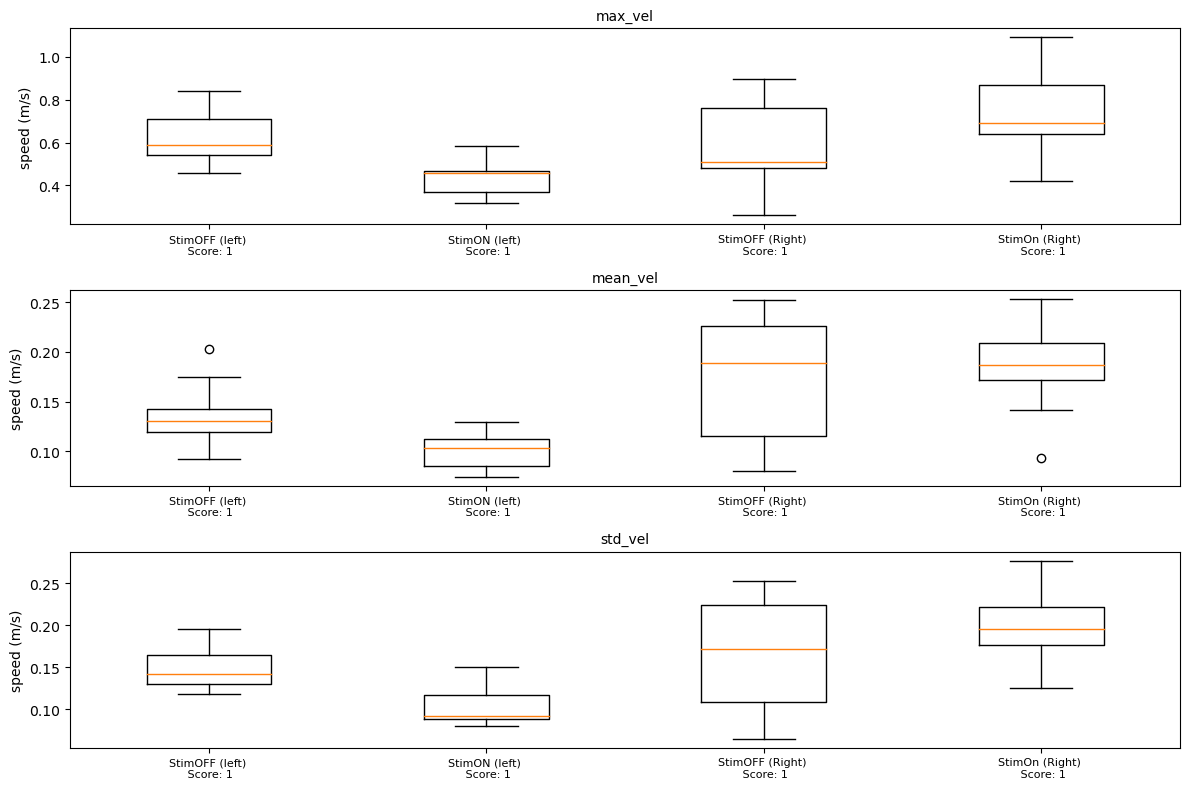

In [114]:
fig, axes = plt.subplots(len(boxplot_of_features.keys()), 1, figsize=(12, 8))

feat_names_vel = ['max_vel', 'mean_vel', 'std_vel']
ylabels = ['speed (m/s)', 'speed (m/s)', 'speed (m/s)']
xticklabels = ['StimOFF (left) \n Score: 1', 'StimON (left) \n Score: 1', 'StimOFF (Right) \n Score: 1', 'StimOn (Right) \n Score: 1']

for n, feat in enumerate(feat_names_vel):

#    axes[n].boxplot(feat_patients[feat].values.tolist())
    axes[n].boxplot(boxplot_of_features[feat])
    axes[n].set_title(feat, fontsize = 10)
    axes[n].set_xticklabels(xticklabels, fontsize = 8)
    axes[n].set_ylabel(ylabels[n])
    # axes[n].set_xlabel()

plt.tight_layout()
# fig.savefig(
#             os.path.join(fig_dir[3], 'ul004_m1sX_vr_oc_dist_spe_boxplot'),
#             dpi = 300, facecolor = 'w',
#         )
plt.show()

STOP

In [ ]:
def speed_from_distance(df, dist: list, max_idx, min_idx):
    
    """
    Convert whole distance list/array into
    speed list/array with time-list
    """

    speed = []
    for idx, (i_max, min) in enumerate(zip(max_idx, min_idx[:-1])):

        max_dist_1 = df.iloc[i_max]['distance']

        dist_to_minima = abs(i_max - np.array(min_idx))
        closest_min = np.argmin(dist_to_minima)
        i_min = min_idx[closest_min]
        min_dist = df.iloc[i_min]['distance']

        max_dist_2 = df.iloc[max_idx[idx + 1]]['distance']

        min_dist_1 = df.iloc[min]['distance']
        min_dist_2 = df.iloc[min_idx[idx+1]]['distance']

        # delta_dist_O = max_dist_2 - min_dist_1
        delta_dist_O = max_dist_2 - min_dist

        delta_dist_C = min_dist_1 - max_dist_1

        speed.append(delta_dist_O)

In [116]:
step = 1
speed = []
for i, tap in enumerate(taps_block):
    
    tap_start_idx = block[block['program_time'] == taps_block[i][0]].index[0]
    tap_end_idx = block[block['program_time'] == taps_block[i][1]].index[0]

    # print(tap_start_idx)
    # print(tap_end_idx)

    dist_start = block.iloc[tap_start_idx]['distances']
    dist_end = block.iloc[tap_end_idx]['distances']

    # print(dist_start)
    # print(dist_end)

    ls_time = block.program_time[np.logical_and(block.program_time >= taps_block[0][0],
                block.program_time <= taps_block[-1][1]
                )].tolist()
    
    ls_dist = block.distances[np.logical_and(block.distances >= dist_start,
                block.distances <= dist_end
                )].tolist()


        
    # for i in np.arange(0, block.shape[0] - step, step):

    #     dist1 = block.iloc[i]['distance']
    #     dist2 = block.iloc[i + step]['distance']

    #     time1 = block.iloc[i]['program_time']
    #     time2 = block.iloc[i + step]['program_time']
        
    #     delta_dist = abs(dist2 - dist1)
    #     delta_time = time2 - time1

    #     # assert delta_time > 0, print(
    #     #     f'delta time in speed_total() is {delta_time}'
    #     # )

    #     vel = delta_dist / delta_time

    #     speed.append(vel)


In [ ]:
def calc_speed(block_df, ls_taps, min_idx, step):

    """
        Calculates the speed of movements.
        
        Input:
            - dataframe with time and distance values
             (from calc_amp_OC() function).
        
        Output:
            - speed (list).
    """

    speed = []
    for tap in ls_taps:
        
        tap_start = block_df.iloc[tap[0]]['program_time']
        tap_end = block_df.iloc[tap[1]]['program_time']

        for i in np.arange(0, block_df.shape[0] - step, step):

            dist1 = block_df.iloc[i]['distance']
            dist2 = block_df.iloc[i + step]['distance']

            time1 = block_df.iloc[i]['program_time']
            time2 = block_df.iloc[i + step]['program_time']
            
            delta_dist = abs(dist2 - dist1)
            delta_time = time2 - time1

            # assert delta_time > 0, print(
            #     f'delta time in speed_total() is {delta_time}'
            # )

            vel = delta_dist / delta_time

            speed.append(vel)

    return speed

In [17]:
def calc_speed(block_df, ls_taps, min_idx, step):

    """
        Calculates the speed of movements.
        
        Input:
            - dataframe with time and distance values
             (from calc_amp_OC() function).
        
        Output:
            - speed (list).
    """

    speed = []
    # for tap in ls_taps:

    for i in np.arange(
        block_df.iloc[tap[0]]['program_time'],
        block_df.iloc[tap[1]]['program_time'] - step, 
        step):

        dist1 = block_df.iloc[i]['distance']
        dist2 = block_df.iloc[i + step]['distance']

        time1 = block_df.iloc[i]['program_time']
        time2 = block_df.iloc[i + step]['program_time']
        
        delta_dist = abs(dist2 - dist1)
        delta_time = time2 - time1

        # assert delta_time > 0, print(
        #     f'delta time in speed_total() is {delta_time}'
        # )

        vel = delta_dist / delta_time

        speed.append(vel)


    # for i in np.arange(0, df_block.shape[0] - step, step):

    #     dist1 = df_block.iloc[i]['distance']
    #     dist2 = df_block.iloc[i + step]['distance']

    #     time1 = df_block.iloc[i]['program_time']
    #     time2 = df_block.iloc[i + step]['program_time']
        
    #     delta_dist = abs(dist2 - dist1)
    #     delta_time = time2 - time1

    #     # assert delta_time > 0, print(
    #     #     f'delta time in speed_total() is {delta_time}'
    #     # )

    #     vel = delta_dist / delta_time

    #     speed.append(vel)
    
    return speed

In [ ]:
def speed_from_distance(df, dist: list, max_idx, min_idx):
    
    """
    Convert whole distance list/array into
    speed list/array with time-list
    """

    speed = []
    for idx, (i_max, min) in enumerate(zip(max_idx, min_idx[:-1])):

        max_dist_1 = df.iloc[i_max]['distance']

        #### NEW

        dist_to_minima = abs(i_max - np.array(min_idx))
        closest_min = np.argmin(dist_to_minima)
        i_min = min_idx[closest_min]
        min_dist = df.iloc[i_min]['distance']

        ####

        max_dist_2 = df.iloc[max_idx[idx + 1]]['distance']

        min_dist_1 = df.iloc[min]['distance']
        min_dist_2 = df.iloc[min_idx[idx+1]]['distance']

# delta_dist_O = max_dist_2 - min_dist_1
        delta_dist_O = max_dist_2 - min_dist

        delta_dist_C = min_dist_1 - max_dist_1

        speed.append(delta_dist_O)
    return speed

### extract tap-timings from blocks


result should be:[
    [tap_start_index, tap_end_index],
    [tap_start_index, tap_end_index],
    [tap_start_index, tap_end_index],
    [tap_start_index, tap_end_index],
]

or list with indices dividing taps

In [149]:
importlib.reload(hp)
idx_max, idx_min = hp.find_min_max(np.array(dist), cam='vr')

In [155]:
def extract_features(distances, speed, tap_indices):

    total_ft_list = []
    ft_names = ['max_dist', 'mean_dist', 'std_dist', 'max_vel', 'mean_vel', 'std_vel']  # list with features in correct order


    for tap_start in tap_indices:

        tap_ft_list = []

        dist_within_tap = distances[tap_indices]

        # calc all feats, and add to list

        total_ft_list.append(tap_ft_list)

    
    return total_ft_list, ft_names

        

Plotting Minima and Maxima Function

In [19]:
def plot_min_max(df, peaks_idx_max, peaks_idx_min, sub, state, cam, task, side, figname):
    """
        Plotting the minima and maxima of a dataframe.
        
        Input:
            - dataframe with time and distance values
             (from a calculating distance/angle function),
             sub (str), cam (str), task (str), side (str), 
             figname (str)).
        
        Output:
            - figure with maxima and minima.
    """
    fig = plt.figure(figsize = (18,5))

    sig_distance = np.array(df['distance'])
    plt.plot(df['program_time'], sig_distance)
    plt.xlabel('time (s)')
    plt.ylabel('distance (m)')
    plt.scatter(df.iloc[peaks_idx_max]['program_time'], df.iloc[peaks_idx_max]['distance'], color = 'red')
    plt.scatter(df.iloc[peaks_idx_min]['program_time'], df.iloc[peaks_idx_min]['distance'], color = 'orange')

    fig_path = os.path.join(
    import_unity.find_project_dir(os.getcwd()),
    'figures',
    sub,
    )

    fig.savefig(
    os.path.join(fig_path, f'{sub}_{state}_{cam}_{task}_{figname}_{side}'),
    dpi = 300, facecolor = 'w',
    )
    plt.close()

    return

Automating code

In [210]:
ls_cam = ['vr', 'desktop']
ls_state = ['m1s0', 'm1s1']
ls_side = ['left', 'right']
task = 'oc'
ls_subs = find_available_subs()[2:4]
finger = 'middle_tip'


for sub in ls_subs:
    for cam in ls_cam:
        for state in ls_state:
            for side in ls_side:
                path = find_file_path(sub, cam, task, state, side)
                # load selected file
                df = import_dat.import_string_data(path)
                # clean data
                df = import_dat.remove_double_and_onlyNan_rows(df)
                # dist_time dataframe 
                df = hp.OC_amp_fing(df, finger)
                
                # loading the time stamps excel table
                time_stamps = pd.read_excel(
                    os.path.join(import_dat.find_onedrive_path()[0], 'oc_time_stamps.xlsx'), 
                    sheet_name = side,
                    usecols = ['ulxxx_mxsx_cam_side', '1st block ul task start time', '1st block ul task end time', '2nd block ul task start time', '2nd block ul task end time'])
                time_stamps.set_index('ulxxx_mxsx_cam_side', inplace = True)

                if side == 'left':
                    t_start_b1 = time_stamps['1st block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_lh'] #ul003_m1s0_vr_oc_lh'
                    t_end_b1 = time_stamps['1st block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_lh']
                    t_start_b2 = time_stamps['2nd block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_lh']
                    t_end_b2 = time_stamps['2nd block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_lh']


                    df1 = task_extraction(df, t_start_b1, t_end_b1)
                    df2 = task_extraction(df,  t_start_b2, t_end_b2)

                if side == 'right':
                    t_start_b1 = time_stamps['1st block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_rh'] #ul003_m1s0_vr_oc_rh'
                    t_end_b1 = time_stamps['1st block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_rh']
                    t_start_b2 = time_stamps['2nd block ul task start time'].loc[f'{sub}_{state}_{cam}_oc_rh']
                    t_end_b2 = time_stamps['2nd block ul task end time'].loc[f'{sub}_{state}_{cam}_oc_rh']

                    df1 = task_extraction(df, t_start_b1, t_end_b1)
                    df2 = task_extraction(df,  t_start_b2, t_end_b2)

                
                
                # Calculating minima and maxima for each camera position
                if cam == 'vr':
                    sig_distance = np.array(df['distance'])

                    peaks_idx_max, peaks_hgt_max = find_peaks(
                        df['distance'], 
                        height=.03,  # not adding something for now
                        prominence = 0.01,  # prominence of 1 cm
                        wlen=30,  # prominence versus a window of 20 samples around the peak
                        distance=90 / 6,  # peaks are at least 1 / 6 seconds from each other
                    )

                    peaks_idx_min, peaks_hgt_min = find_peaks(
                        -sig_distance,
                        height=np.mean(-sig_distance) - np.std(-sig_distance),
                        distance=90 / 5,
                        prominence=.001, wlen=30,
                        )

                    plot_min_max(df, peaks_idx_max, peaks_idx_min, sub, state, cam, task, side, 'dist_whole_mov_min_max')

                if cam == 'desktop':
                    
                    sig_distance = np.array(df['distance'])

                    peaks_idx_max, peaks_hgt_max = find_peaks(
                        df['distance'], 
                        height = np.mean(df['distance'])-np.std(df['distance']),
                        prominence = 0.02
                    )

                    peaks_idx_min, peaks_hgt_min = find_peaks(
                        -sig_distance,
                        height = np.mean(-sig_distance)-np.std(-sig_distance), 
                        # (np.mean(-np.array(df2_dist_lh['distance']))+4*np.std(-np.array(df2_dist_lh['distance'])))), 
                        prominence = 0.02
                        )

                    plot_min_max(df, peaks_idx_max, peaks_idx_min, sub, state, cam, task, side, 'dist_whole_mov_min_max')

                print(f'{path} \n')    

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s0_vr_oc\ul003_m1s0_vr_oc_lh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s0_vr_oc\ul003_m1s0_vr_oc_rh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s1_vr_oc\ul003_m1s1_vr_oc_lh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\vr\ul003_m1s1_vr_oc\ul003_m1s1_vr_oc_rh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\desktop\ul003_m1s0_desktop_oc\ul003_m1s0_desktop_oc_lh.csv 

c:\Users\madal\OneDrive - Charité - Universitätsmedizin Berlin\Ultraleap-hand-tracking\data\Patientdata\ul003\desktop\ul003_m1s0_desktop_oc\ul003_m1s0_desktop_oc_rh.csv 

c:\Users\madal\OneDrive - Charité 

In [ ]:
# dataframes per block
block_dfs = {0: task_extraction(df_003_M1S0_VR_ft_rh, '09:38:14', '09:38:25'), 1: task_extraction(df_003_M1S0_VR_ft_rh, '09:38:37', '09:38:47')}

block_feats = {}

for b in block_dfs.keys():
    block_feats[b] = {}
    
    ft_dist = hp.FT_amp(block_dfs[b], 'index_tip', 'thumb_tip')
    dict_min_max = hp.find_min_max(
        ft_dist,
        0.04,
        'distance',
        0.03,
    )
    min_idx, max_idx = dict_min_max['min_idx'], dict_min_max['max_idx']
    max_dist = dict_min_max['max_values']

    block_feats[b]['max_distances'] = max_dist

    for i_tap in np.arange(len(max_idx) - 1):

        tap_start = max_idx[i_tap]
        tap_end = max_idx[i_tap + 1]

        tap_speed = hp.speed_total(ft_dist, 1).iloc[tap_start:tap_end]


    block_feats[b]['mean_speed_block'] = np.mean(hp.speed_total(ft_dist, 1))
    block_feats[b]['max_speed_block'] = np.max(hp.speed_total(ft_dist, 1))
    block_feats[b]['stddev_speed_block'] = np.nanstd(hp.speed_total(ft_dist, 1))

### Plotting Function for different states

In [161]:
def plot_mxsx(sub, ls_dfs, fig_titles, fig_dir, fig_name):
    fig, axes = plt.subplots(2, 2, figsize = (14, 10))

    xlabel, ylabel = ['program_time (s)', 'distance (m)']

    idx = 0
    for i in np.arange(2):
        for j in np.arange(2):
            axes[i][j].plot(
            ls_dfs[idx]['program_time'],
            ls_dfs[idx]['distance']
            )
            axes[i][j].set_title(fig_titles[idx])
            axes[i][j].set_xlabel(xlabel)
            axes[i][j].set_ylabel(ylabel)
            idx += 1
        
    
    fig.suptitle(f'ul{sub} - Opening-Closing 1', fontweight ="bold")
    fig.savefig(
                os.path.join(fig_dir, fig_name),
                dpi = 150, facecolor = 'w',
            )
    plt.tight_layout()

    return

Plotting first block

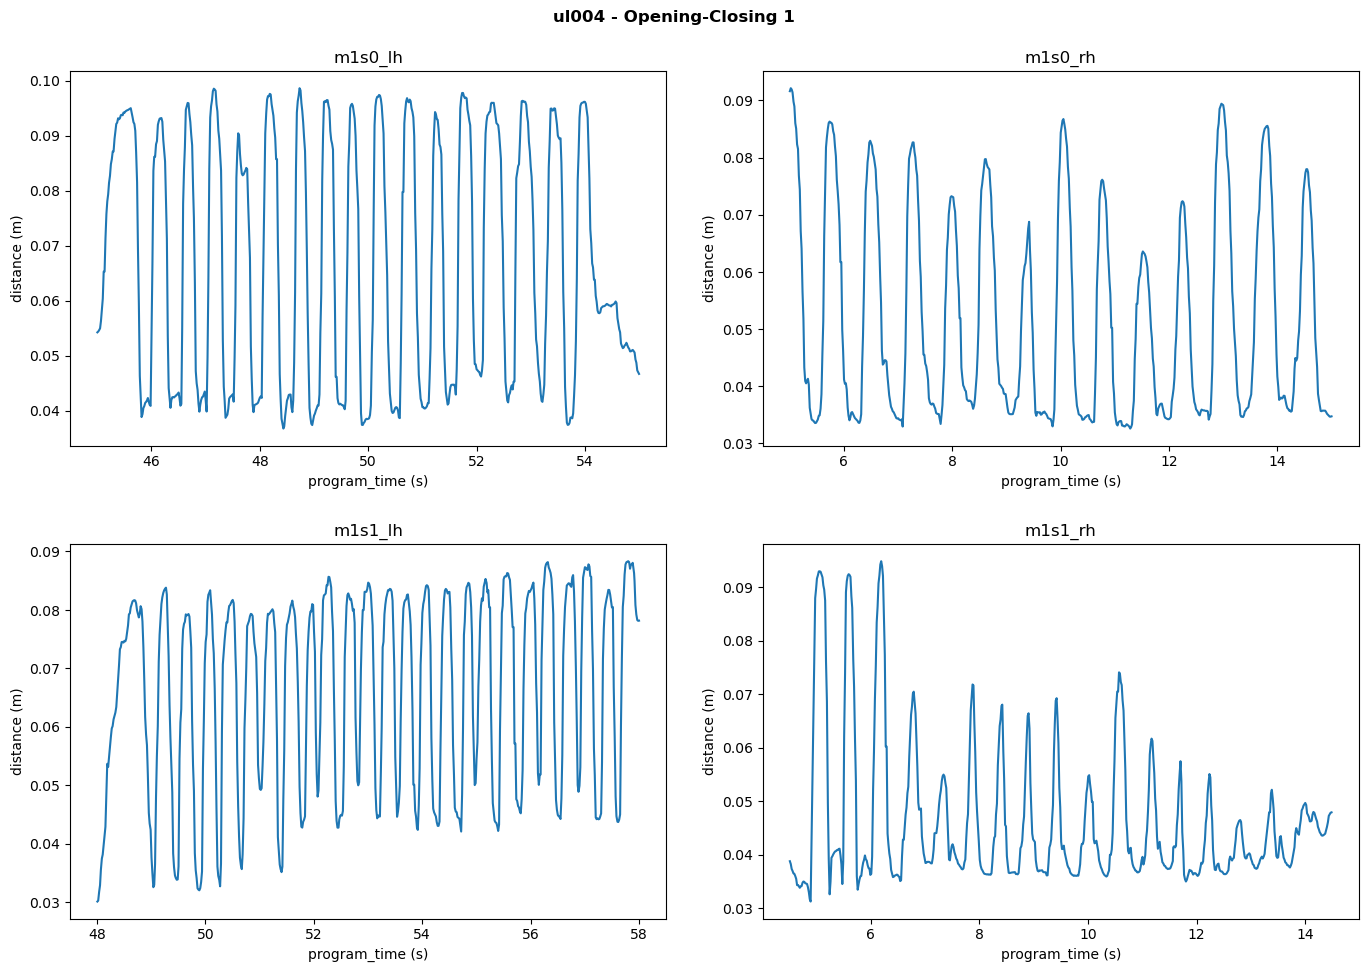

In [164]:
ls_dist_plt_1 = [df1_dist_lh_1, df1_dist_rh_1, df2_dist_lh_1, df2_dist_rh_1]
ls_fig_titles_dist_1 = ['m1s0_lh', 'm1s0_rh', 'm1s1_lh', 'm1s1_rh']
dir_fig_dist_1 = fig_dir[3]
plot_dist_1 = plot_mxsx('004', ls_dist_plt_1, ls_fig_titles_dist_1, dir_fig_dist_1, 'ul004_m1sX_vr_oc_1st_block')

Plotting second block

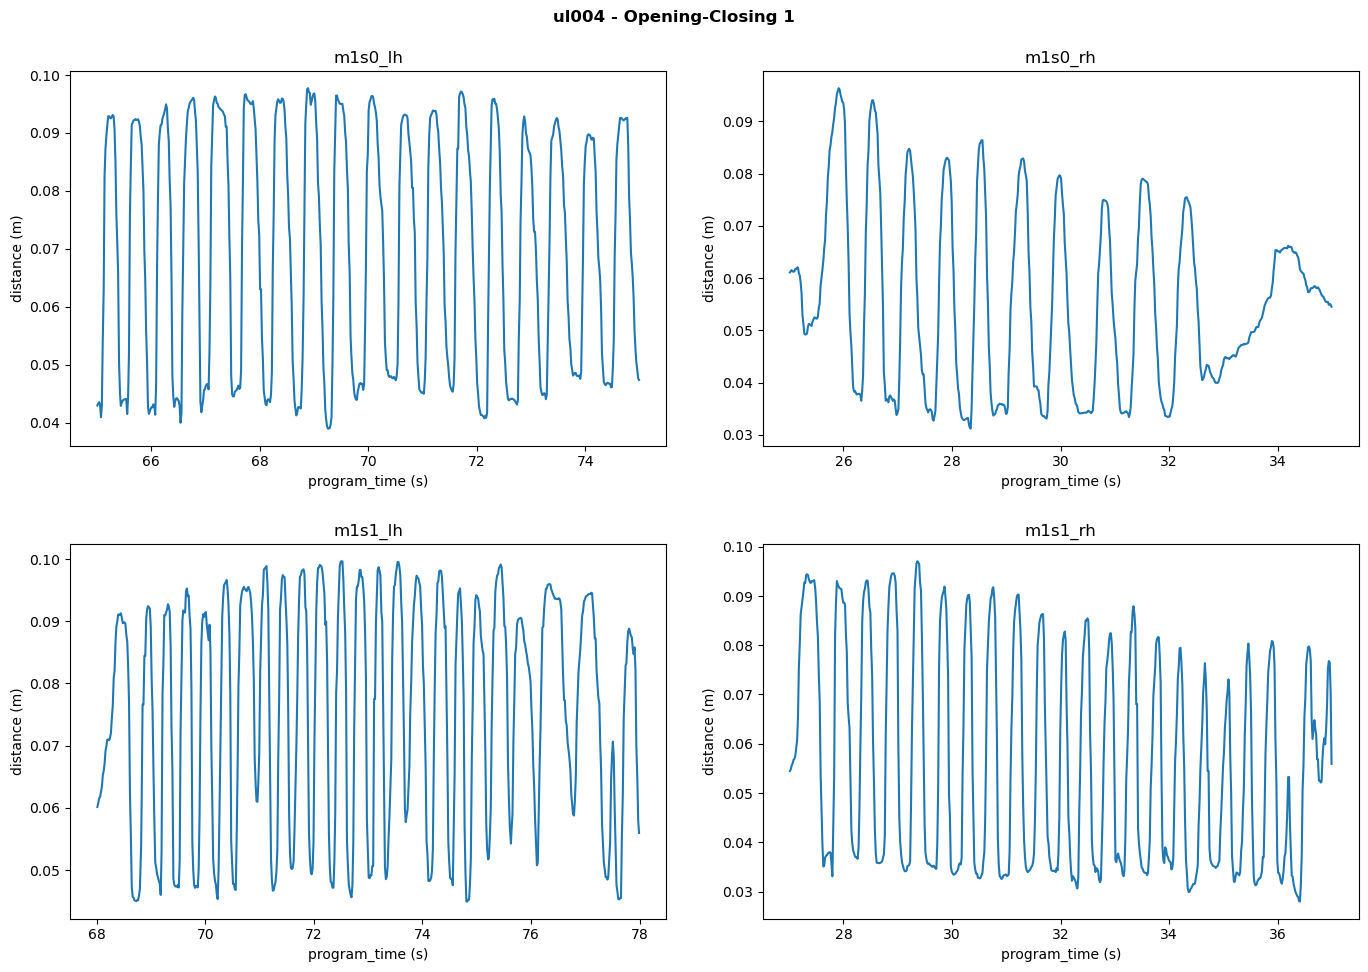

In [165]:
ls_dist_plt_2 = [df1_dist_lh_2, df1_dist_rh_2, df2_dist_lh_2, df2_dist_rh_2]
ls_fig_titles_dist_2 = ['m1s0_lh', 'm1s0_rh', 'm1s1_lh', 'm1s1_rh']
dir_fig_dist_2 = fig_dir[3]
plot_dist_2 = plot_mxsx('004', ls_dist_plt_2, ls_fig_titles_dist_2, dir_fig_dist_2, 'ul004_m1sX_vr_oc_2nd_block')


### Boxplot Function

In [73]:
def boxplots(ls_featname, xticklabels, ylabels, ls_feat1, ls_feat2, figdir, figname):

        boxplot_dict = {
        ls_featname[0]: ls_feat1,
        ls_featname[1]: ls_feat2
        }

     
        for n, feat in enumerate(ls_featname):

        #    axes[n].boxplot(feat_patients[feat].values.tolist())
            axes[n].boxplot(boxplot_dict[feat])
            axes[n].set_title(feat)
            axes[n].set_xticklabels(xticklabels)
            axes[n].set_ylabel(ylabels[n])
            # axes[n].set_xlabel()

        plt.tight_layout
        fig.savefig(
                    os.path.join(figdir, figname),
                    dpi = 300, facecolor = 'w',
                )
        plt.show()
        
        return

In [74]:
oc_list_to_plot = ['open_dist', 'speed_of_movement']
ylabels = ['distance (m)', 'speed (m/s)']#, 'Freq (Hz)']
xticklabels = ['StimOFF (Left) \n Score: 2', 'StimON (Left) \n Score: 2', 'StimOFF (Right) \n Score: 3', 'StimOn (Right) \n Score: 2.5']
ls_feat1 = [ampO_df1_dist_lh, ampO_df2_dist_lh, ampO_df1_dist_rh, ampO_df2_dist_rh]
ls_feat2 = [spe_df1_dist_lh, spe_df2_dist_lh, spe_df1_dist_rh, spe_df2_dist_rh]
figname = 'ul004_m1sX_vr_oc_dist_spe_boxplot'
fg_dir = fig_dir[3]
boxplots(oc_list_to_plot, xticklabels, ylabels, ls_feat1, ls_feat2, fg_dir, figname)

NameError: name 'ampO_df1_dist_lh' is not defined

Boxplots

In [56]:
boxplot_dict = {
    'open_dist': [ampO_df1_dist_lh, ampO_df2_dist_lh, ampO_df1_dist_rh, ampO_df2_dist_rh],
    'speed_of_movement': [spe_df1_dist_lh, spe_df2_dist_lh, spe_df1_dist_rh, spe_df2_dist_rh]
}

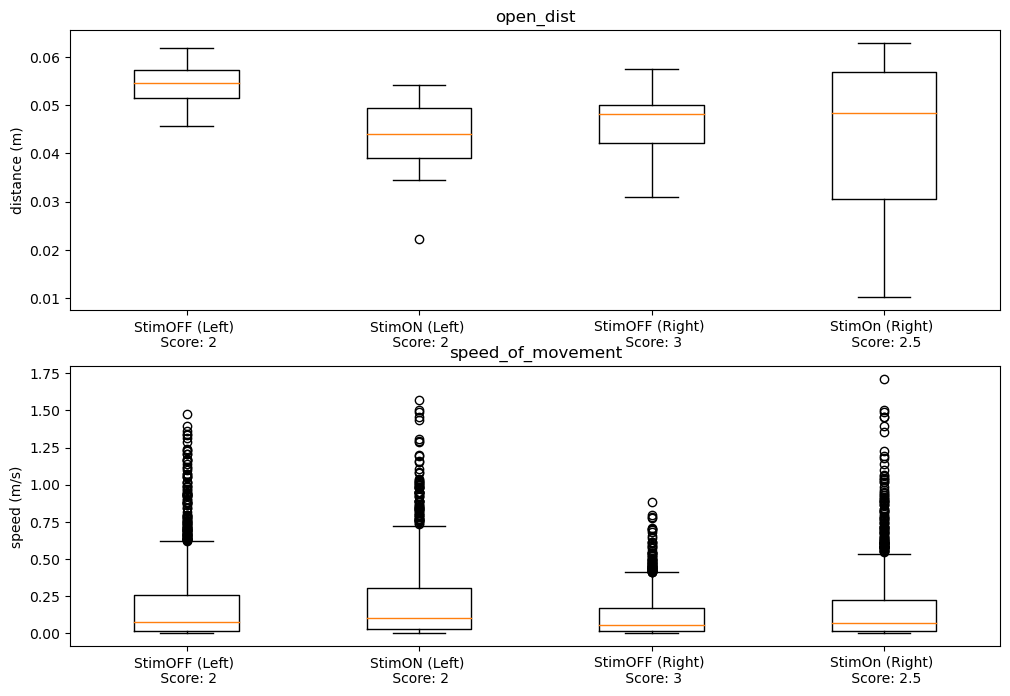

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

oc_list_to_plot = ['open_dist', 'speed_of_movement']#, 'mean_freq']
ylabels = ['distance (m)', 'speed (m/s)']#, 'Freq (Hz)']
xticklabels = ['StimOFF (Left) \n Score: 2', 'StimON (Left) \n Score: 2', 'StimOFF (Right) \n Score: 3', 'StimOn (Right) \n Score: 2.5']
for n, feat in enumerate(oc_list_to_plot):

#    axes[n].boxplot(feat_patients[feat].values.tolist())
    axes[n].boxplot(boxplot_dict[feat])
    axes[n].set_title(feat)
    axes[n].set_xticklabels(xticklabels)
    axes[n].set_ylabel(ylabels[n])
    # axes[n].set_xlabel()

plt.tight_layout
fig.savefig(
            os.path.join(fig_dir[3], 'ul004_m1sX_vr_oc_dist_spe_boxplot'),
            dpi = 300, facecolor = 'w',
        )
plt.show()

SPEED_OC NEW

In [134]:
def speed_OC_time_series(
    df,
    max_idx,
    min_idx
    ):

    """
    Calculates the speed of opening and closing.
    
    Input:
        - df (cleaned DataFrame), max_idx list, 
        min_idx list.
    
    Output:
        - dict: dictionary with pronation and 
        supination speeds.
    """

    speed_O = []
    speed_C = []

    for idx, (max, min) in enumerate(zip(max_idx, min_idx[:-1])):
        # max_idx[0] < min_idx[0] means that the patient started the exercise with pronation
        if max_idx[0] < min_idx[0]:
            
            max_dist_1 = df.iloc[max]['distance']
            max_dist_2 = df.iloc[max_idx[idx + 1]]['distance']
            max_time_1 = df.iloc[max]['program_time']
            max_time_2 = df.iloc[max_idx[idx + 1]]['program_time']

            min_dist_1 = df.iloc[min]['inv_distance']
            min_dist_2 = df.iloc[min_idx[idx+1]]['inv_distance']
            min_time_1 = df.iloc[min]['program_time']

            delta_dist_O = max_dist_2 - min_dist_1
            delta_time_O = max_time_2 - min_time_1

            delta_dist_C = min_dist_1 - max_dist_1
            delta_time_C = min_time_1 - max_time_1

            vel_O = delta_dist_O/delta_time_O
            vel_C = delta_dist_C/delta_time_C

            speed_O.append(vel_O)
            speed_C.append(vel_C)

        # max_idx[0] > min_idx[0] means that the patient started the exercise with supination
        # if max_idx[0] > min_idx[0]:
        else:
            max_dist_1 = df.iloc[max]['distance']
            max_time_1 = df.iloc[max]['program_time']

            min_dist_1 = df.iloc[min]['inv_distance']
            min_time_1 = df.iloc[min]['program_time']
            min_dist_2 = df.iloc[min_idx[idx + 1]]['inv_distance']
            min_time_2 = df.iloc[min_idx[idx + 1]]['program_time']

            delta_dist_O = max_dist_1 - min_dist_1
            delta_time_O = max_time_1 - min_time_1

            delta_dist_C = min_dist_2 - max_dist_1
            delta_time_C = min_time_2 - max_time_1

            vel_O = delta_dist_O/delta_time_O
            vel_C = delta_dist_C/delta_time_C

            speed_O.append(vel_O)
            speed_C.append(vel_C)
    dict = {'open_speed': speed_O,'close_speed': speed_C}
    return dict

ul001

Frequency per Opening-Closing 

In [46]:
def freq_tap(df_time_amp, min_idx):

    freq_per_tap = []

    for idx, min in enumerate(min_idx[:-1]):

        min_time1 = df_time_amp.iloc[min]['program_time']
        min_time2 = df_time_amp.iloc[min_idx[idx+1]]['program_time']
   
        delta_time = min_time2-min_time1
        freq = 1/delta_time

        freq_per_tap.append(freq)
        # time_ls.append(delta_time)
    std_freq = np.std(freq_per_tap)

    dict_freq_std = {'std_freq': std_freq, 'freq_per_tap': freq_per_tap}

    return dict_freq_std

Opening-Closing Frequency Standard Deviation

In [47]:
dict_freq_std = freq_tap(dist_df_003_M1S0_DT_oc_rh, min_idx_dist_df_003_M1S0_DT_oc_rh)
std_freq = dict_freq_std['std_freq']
std_freq

0.49719821823963467

Opening-Closing Mean Frequency

In [48]:
mean_freq = np.mean(dict_freq_std['freq_per_tap'])
mean_freq

2.3205798012979177